In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from IPython.display import display, clear_output

/Users/sbatir/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained PyTorch model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/Users/sbatir/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sbatir/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
video_path = 'birds5s.mov'  # Replace with your video path
video = cv2.VideoCapture(video_path)

In [4]:
#import Coco Labels
from coco_label_map import LABEL_MAP


CPU times: user 15min 20s, sys: 2min 31s, total: 17min 52s
Wall time: 15min 48s


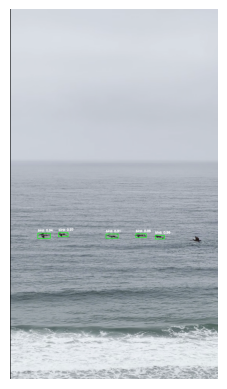

In [7]:
%%time
# Calculate frame rate and set up frame limit
frame_rate = video.get(cv2.CAP_PROP_FPS)
frame_limit = frame_rate * 5  # 5 seconds worth of frames

# Initialize frame count
frame_count = 0

while video.isOpened() and frame_count < frame_limit:
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1

    # Convert the color space from BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 3. Object Detection
    # Convert frame to tensor
    frame_tensor = F.to_tensor(frame_rgb).unsqueeze(0)
    
    # Get predictions from model
    with torch.no_grad():
        predictions = model(frame_tensor)

    # Extract boxes, labels, and scores from predictions
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    # Filter out low-confidence detections

    threshold = 0.8  # Confidence threshold
    high_confidence_boxes = boxes[scores > threshold].numpy()
    for box, label, score in zip(high_confidence_boxes, labels, scores):
        x1, y1, x2, y2 = box
        label_text = f'{LABEL_MAP[label.item()]}: {score:.2f}'
        #print(label_text)
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(frame, label_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # 4. Displaying Frames
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

video.release()
